In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from astropy.stats.circstats import circcorrcoef

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from modelUtils import wrap_180, rot
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

from SacNetwork import SacNetwork
import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

# TODO:
**timing offsets between EI for each direction:**
- collect input locations for EI synapses at each rho level
- calculate the time delta between E and I
- how does this change over direction?

In [4]:
rng = np.random.default_rng()
dir_labels = np.array([225, 270, 315, 0, 45, 90, 135, 180])
dir_rads = np.radians(dir_labels)
conf = configs.sac_mode_config()
probs = {
    t: {
        "null": conf["synprops"][t]["null_prob"],
        "pref": conf["synprops"][t]["pref_prob"],
    }
    for t in ["E", "I"]
}

In [5]:
# def calc_sweep_times(
#     locs, # shape (N, 2 [EI], 2 [XY])
#     origin,
#     vel=1.0,
#     rel_start=np.array([-150, 0]),
#     rel_end=np.array([150, 0]),
# ):
#     times = {}  # dir -> syn -> trans
#     for i, r in enumerate(dir_rads):
#         times[i] = {}
#         line_a = rot(r, rel_start) + origin
#         line_b = rot(r, rel_end) + origin
#         for syn in range(locs.shape[0]):
#             times[i][syn] = np.zeros(2)
#             for j in range(2):
#                 dist = project_onto_line(line_a, line_b, locs[syn][j])[0]
#                 times[i][syn][j] = dist / vel
                
#     return times

def calc_sweep_times(
    locs, # shape (N, 2 [EI], 2 [XY])
    origin,
    vel=1.0,
    rel_start=np.array([-150, 0]),
    rel_end=np.array([150, 0]),
):
    times = {}  # dir -> syn -> trans
    times = np.zeros((len(dir_rads), locs.shape[0], 2))
    for i, r in enumerate(dir_rads):
        line_a = rot(r, rel_start) + origin
        line_b = rot(r, rel_end) + origin
        for syn in range(locs.shape[0]):
            for j in range(2):
                dist = project_onto_line(line_a, line_b, locs[syn][j])[0]
                times[i, syn, j] = dist / vel
                
    return times

In [27]:
n_syns = 2000
rho_steps = 50
rhos = np.arange(rho_steps + 1) / rho_steps 

thetas, deltas, abs_deltas, dir_probs, times = [{} for _ in range(5)]
corrs, mean_abs_deltas = [], []

for rho in rhos:
    sac_net = SacNetwork(
        np.zeros((n_syns, 2)),
        probs,
        rho,
        conf["sac_uniform_dist"],
        conf["sac_shared_var"],
        conf["sac_theta_vars"],
        conf["sac_gaba_coverage"],
        dir_labels,
        rng,
        offset=conf["sac_offset"],
        theta_mode=conf["sac_theta_mode"],
        cell_pref=0,
        n_plexus_ach=0,
    )
    n = np.sum(sac_net.gaba_here)
    ts = np.zeros((n, 2))
    ts[:, 0] = sac_net.thetas["E"][sac_net.gaba_here]
    ts[:, 1] = sac_net.thetas["I"][sac_net.gaba_here]
    thetas[rho] = ts
    corrs.append(circcorrcoef(np.radians(ts[:, 0]), np.radians(ts[:, 1])))
    deltas[rho] = np.vectorize(wrap_180)(ts[:, 0] - ts[:, 1])
    abs_deltas[rho] = np.abs(deltas[rho])
    mean_abs_deltas.append(np.mean(abs_deltas[rho]))
    locs = np.zeros((n, 2, 2))
    locs[:, 0, :] = sac_net.bp_locs["E"][sac_net.gaba_here]
    locs[:, 1, :] = sac_net.bp_locs["I"][sac_net.gaba_here]
    times[rho] = calc_sweep_times(locs, sac_net.origin)
    dir_probs[rho] = np.zeros((n, 8, 2))
    dir_probs[rho][:, :, 0] = sac_net.probs["E"][sac_net.gaba_here]
    dir_probs[rho][:, :, 1] = sac_net.probs["I"][sac_net.gaba_here]

corrs = np.array(corrs)

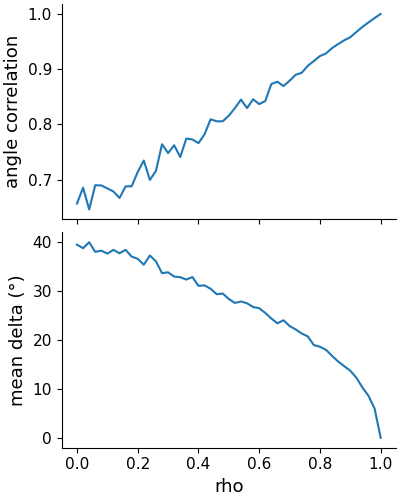

In [28]:
real_corr_fig, real_corr_ax = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
real_corr_ax[0].plot(rhos, corrs)
real_corr_ax[0].set_ylabel("angle correlation", fontsize=13)
real_corr_ax[1].plot(rhos, mean_abs_deltas)
real_corr_ax[1].set_ylabel("mean delta (°)", fontsize=13)
real_corr_ax[-1].set_xlabel("rho", fontsize=13)
real_corr_fig.set_layout_engine("compressed")
clean_axes(real_corr_ax)

In [33]:
e_early_thresh = 5.

time_diff = {r: ts[:, :, 1] - ts[:, :, 0] for r, ts in times.items()}
abs_time_diff = {r: np.abs(diffs) for r, diffs in time_diff.items()}
abs_time_diff_sum = {r: np.sum(diffs, axis=1) for r, diffs in abs_time_diff.items()}
e_early_diff_sum = {
    r: np.array([np.sum(d[d > 0.]) for d in diff]) 
    for r, diff in time_diff.items()
}
e_early = {r: (diffs > e_early_thresh) for r, diffs in time_diff.items()}
e_early_sum = {r: np.sum(early, axis=1) for r, early in e_early.items()}

{0.0: array([313, 326, 320, 314, 309, 313, 293, 278]),
 0.02: array([310, 328, 323, 333, 312, 320, 325, 316]),
 0.04: array([320, 335, 308, 293, 311, 322, 316, 315]),
 0.06: array([314, 311, 298, 296, 282, 316, 298, 296]),
 0.08: array([308, 307, 300, 295, 299, 321, 292, 304]),
 0.1: array([321, 357, 338, 337, 335, 325, 336, 317]),
 0.12: array([313, 312, 316, 306, 307, 306, 315, 319]),
 0.14: array([281, 303, 296, 293, 314, 345, 321, 293]),
 0.16: array([279, 304, 296, 317, 314, 327, 303, 299]),
 0.18: array([315, 320, 311, 283, 278, 289, 277, 290]),
 0.2: array([287, 318, 324, 314, 309, 308, 293, 283]),
 0.22: array([294, 290, 303, 301, 291, 300, 286, 293]),
 0.24: array([322, 313, 314, 313, 339, 356, 333, 303]),
 0.26: array([291, 292, 285, 293, 299, 312, 317, 304]),
 0.28: array([286, 301, 296, 307, 300, 298, 295, 279]),
 0.3: array([280, 283, 282, 272, 286, 291, 281, 284]),
 0.32: array([265, 283, 297, 294, 310, 294, 263, 267]),
 0.34: array([289, 310, 303, 295, 289, 296, 278, 277

In [31]:
dir_labels

array([225, 270, 315,   0,  45,  90, 135, 180])